In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.storage import Storage
storage = Storage("mstis.nc")

In [2]:
mstis = storage.networks.load(0)

In [3]:
print mstis

Multiple State TIS Network:
RETISTransition: Out B
B -> B or all states except B
Interface: 0.0<opB<0.04
Interface: 0.0<opB<0.09
Interface: 0.0<opB<0.16
RETISTransition: Out A
A -> A or all states except A
Interface: 0.0<opA<0.04
Interface: 0.0<opA<0.09
Interface: 0.0<opA<0.16
RETISTransition: Out C
C -> C or all states except C
Interface: 0.0<opC<0.04
Interface: 0.0<opC<0.09
Interface: 0.0<opC<0.16



In [4]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [5]:
#import logging.config
#logging.config.fileConfig("debug_logging.conf", disable_existing_loggers=False)
#logging.getLogger("openpathsampling.analysis.wham").setLevel(logging.DEBUG)

In [6]:
mstis.rate_matrix(storage)

/Users/jan-hendrikprinz/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0,0
"{x|opB(x) in [0.0, 0.04]}",NaN,NaN,NaN
"{x|opC(x) in [0.0, 0.04]}",0,0,NaN


In [7]:
stateA = storage.volumes.find_first("A")
stateB = storage.volumes.find_first("B")
stateC = storage.volumes.find_first("C")

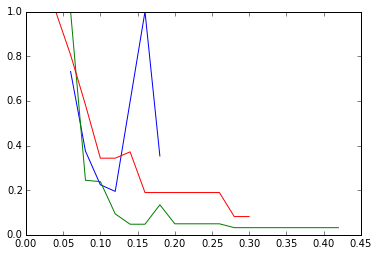

In [8]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp

plt.plot(tcp_AB.keys(), tcp_AB.values())
plt.plot(tcp_CA.keys(), tcp_CA.values())
plt.plot(tcp_BC.keys(), tcp_BC.values())